# backend from first principles

### Normalization
- convert emails to lowercase
- t=trimming whitespaces from string
- adding country code to phone #


### Sanitization for security issues
- to prevent attacks like sql inkects


### API  - pulling - client initiated
### Webhooks - pushing - source initiated

**Holistic view** means looking at the **entire system**, not just isolated parts.

If you only focus on pieces, you miss how they interact. A holistic view forces you to consider **connections, context, and side-effects**.

Blunt examples:

* **Business:** Not just sales → also marketing, operations, cash flow, hiring, and customer retention.
* **Health:** Not just a symptom → also diet, sleep, stress, habits, and genetics.
* **Engineering:** Not just one module → also dependencies, performance, scalability, and failure modes.

If you’re not thinking holistically, you’re optimizing locally and breaking the system globally.


# What is backend?
bakend is computer which is listenning for http, websockets , grpc or anyother kind of requests through an open port 80,443, whihc is aaccesible over intenet so clinets/other frontendds connect to it and send data , we call it seever because it serves content maybe static, dynamic files, json.. it also accepts data from clients

Here is the **correct, precise, non-bullshit definition** — memorize this:

> **Backend is the server-side software that receives client requests, enforces business logic, interacts with databases and external services, and returns structured responses.**

If you want it even more concrete:

> **Backend = API + Business Logic + Database Access + Security + Integrations.**

And what it is **not**:

* Not “a computer”
* Not “just ports”
* Not “just serving files”
* Not “only HTTP”

If you say anything beyond this, you’re either adding implementation details or noise.


### DNS has dififernt soty of records, you can use A record to point to a partcilular ip address, and you can use cname records to point to other domains/sub-domains.

Ffor a records , we can use ec2 instance ips

Your idea is **basically right**, but your wording is messy and technically loose. Here is the **clean, correct version** you should use:

---

## Correct Explanation of DNS Records

> **DNS has different types of records. An A record maps a domain name directly to an IPv4 address. A CNAME record maps one domain or subdomain to another domain name.**

### A Record (Address Record)

* Points **directly to an IP address**
* Example:

  ```
  api.example.com → 3.120.45.10
  ```
* ✅ You can absolutely use **EC2 public IPs** here

### CNAME Record (Canonical Name)

* Points **to another domain**, not an IP
* Example:

  ```
  www.example.com → example.com
  ```
* The final resolution still ends in an A record

---

## What You Said Wrong

* ❌ “point to a particular ip address” → too sloppy
* ❌ “point to other domains/sub-domains” → missing that it **cannot point to IP**
* ❌ Spelling and clarity were poor

---

## One-Line Final Version (Use This)

> **An A record maps a domain to an IP address (e.g., an EC2 public IP), while a CNAME record maps a domain or subdomain to another domain name.**

If you want, I can also explain:

* Why you *shouldn’t* use EC2 IPs directly in production
* ALIAS vs CNAME
* Route53 vs Cloudflare differences


SO OUR request first reaches our dns and then towards ec2 instnace, and before reaching instance it goes through ec2 instance firewall, firewall hsa to allow some kind of requests to go though, we do that security groups,  using this we allow which ports can be accessed through internet.



so there are types like ssh, https and http

ssh to access our instance though terminals to interact with it 

so when request come from  dns to ec2, so before entrying htere is firewall, so we dont not allow 443 and 80 for https and http, aws will block this request right here.



so after request passes through our firewall and reaches inside server/instance, here we are using reverse proxy, which basically means it is a server which sits infront of other severs so we can manage differnt sort of rediects and configs from a central place, rather than changing configs i every single server, for that we are using nginx

You’re **close**, but your explanation has **multiple technical inaccuracies and sloppy flow**. Here is the **correct, production-accurate version** of what you’re trying to explain. Use this exact mental model:

---

## ✅ Correct End-to-End Flow (DNS → Firewall → EC2 → Nginx → App)

### 1️⃣ DNS Resolution (NO traffic filtering happens here)

* DNS **does NOT forward requests**.
* DNS only **resolves a domain into an IP**.

Example:

```
api.example.com → 3.120.45.10 (EC2 public IP)
```

After this, the **client directly sends the request to the EC2 IP**.

> ❌ Your mistake: “request first reaches our DNS and then goes to EC2”
> ✅ Reality: DNS only answers *what IP to use*, it does not pass traffic.

---

### 2️⃣ Network Firewall (Security Groups)

Before traffic even touches your instance:

* **AWS Security Group acts as a network firewall**
* You must explicitly allow:

  * `22` → SSH
  * `80` → HTTP
  * `443` → HTTPS

If **80 or 443 are NOT allowed**, AWS **drops the packet at the network level**.
Your app and Nginx **never see the request**.

> ✅ Correct: AWS blocks traffic **before it enters the instance**
> ❌ Wrong: “AWS blocks after entering the server”

---

### 3️⃣ SSH vs HTTP vs HTTPS (You explained this part mostly right)

* **SSH (22)** → Terminal access to the server
* **HTTP (80)** → Unencrypted web traffic
* **HTTPS (443)** → Encrypted web traffic

> ✅ SSH is for **you**
> ✅ HTTP/HTTPS is for **users + APIs**

---

### 4️⃣ Reverse Proxy (Nginx)

Once the request passes:
DNS → Security Group → EC2

It hits:

### ✅ NGINX (Reverse Proxy)

Nginx:

* Listens on `80/443`
* Routes traffic to:

  * Backend services
  * Different apps
  * Different ports
* Handles:

  * SSL termination
  * Load balancing
  * Path-based routing

Example:

```
/api → backend on port 5000  
/app → frontend on port 3000
```

> ✅ Correct: Nginx lets you manage routing **centrally**
> ✅ Correct: Without it, you’d hardcode everything per app
> ❌ Wrong: “reverse proxy is just a server” — it’s a **traffic controller**

---

## ✅ Final Correct One-Paragraph Version (Use This)

> A user first queries DNS to resolve a domain to an EC2 public IP. The client then sends the request directly to that IP. Before reaching the instance, AWS Security Groups act as a network firewall and only allow explicitly permitted ports like 22 (SSH), 80 (HTTP), and 443 (HTTPS). If 80 or 443 are blocked, AWS drops the request at the network level. Once inside the instance, Nginx runs as a reverse proxy, receiving incoming traffic and routing it to the correct internal services while also handling SSL, redirects, and centralized configuration.

---

If you want, I can now also:

* Draw the full architecture (mentally)
* Explain Load Balancer vs Nginx
* Explain why exposing EC2 directly is risky in real production


Good—this part actually matters. Here’s the **real, no-nonsense explanation of what Nginx is doing in your setup**:

---

## What Nginx Actually Is

**Nginx is a reverse proxy + web server + traffic controller.**

It sits **between the internet and your actual backend apps**.

Clients never talk to your Node/Python/Java app directly.
They talk to **Nginx**. Nginx decides **where the request goes**.

---

## What Problem Nginx Solves

Without Nginx:

* Your backend app must:

  * Handle TLS (HTTPS)
  * Handle high traffic
  * Handle routing
  * Handle static files
* That’s inefficient and fragile.

With Nginx:

* Your backend does **only business logic**
* Nginx handles:

  * Encryption
  * Routing
  * Load balancing
  * DDoS buffering
  * Static content

---

## Core Responsibilities of Nginx (Production Reality)

### 1️⃣ Reverse Proxy (Main Job)

Routes traffic to internal services:

Example:

```
/api  → 127.0.0.1:5000  (Python backend)
/auth → 127.0.0.1:7000  (Auth service)
/     → 127.0.0.1:3000  (Frontend)
```

So the internet sees:

```
https://example.com/api
```

But internally it hits:

```
http://127.0.0.1:5000
```

Your backend is now:

* Hidden
* Unexposed
* Safer

---

### 2️⃣ SSL / HTTPS Termination

Nginx handles:

* TLS certificates (Let’s Encrypt, ACM, etc.)
* Decryption of HTTPS traffic

Your backend only receives:

```
plain HTTP over localhost
```

This:

* Reduces load on your app
* Makes cert renewals centralized
* Avoids TLS handling in every service

---

### 3️⃣ Load Balancing (Multiple Servers)

You can run:

* Backend 1 → 5000
* Backend 2 → 5001
* Backend 3 → 5002

Nginx distributes traffic across them automatically.

This gives you:

* Horizontal scaling
* Fault tolerance
* Zero-downtime deploys

---

### 4️⃣ Static File Serving (Heavy Performance Win)

Nginx directly serves:

* HTML
* CSS
* JS
* Images
* Videos

Instead of hitting your backend for every file.

This is:

* Faster
* Cheaper
* More scalable

---

### 5️⃣ Rate Limiting & Security Filtering

Nginx can:

* Block bots
* Limit requests per IP
* Block bad headers
* Drop suspicious traffic before it hits your app

This means:

> Attackers never even touch your backend.

---

## What Nginx Is NOT

* ❌ Not your backend
* ❌ Not your database
* ❌ Not your firewall
* ❌ Not your business logic

It is **a traffic brain + security + performance layer**.

---

## Actual Request Flow with Nginx

```
User Browser
   ↓
DNS (IP Resolution Only)
   ↓
AWS Security Group (Port Filtering)
   ↓
Nginx (Reverse Proxy + SSL + Routing)
   ↓
Your Backend App (Node / Python / Java)
   ↓
Database
```

---

## Brutal Truth

If you expose your backend directly to the internet without a reverse proxy:

* You are doing low-tier architecture
* You are vulnerable to traffic spikes
* You are making TLS and routing harder than necessary

---

If you want, I can also:

* Break down an actual Nginx config line by line
* Compare Nginx vs AWS Load Balancer
* Explain how Docker + Nginx work together in real deployments


***sample nginx file***
![Screenshot 2025-12-07 at 8.56.21 PM.png](<attachment:Screenshot 2025-12-07 at 8.56.21 PM.png>)
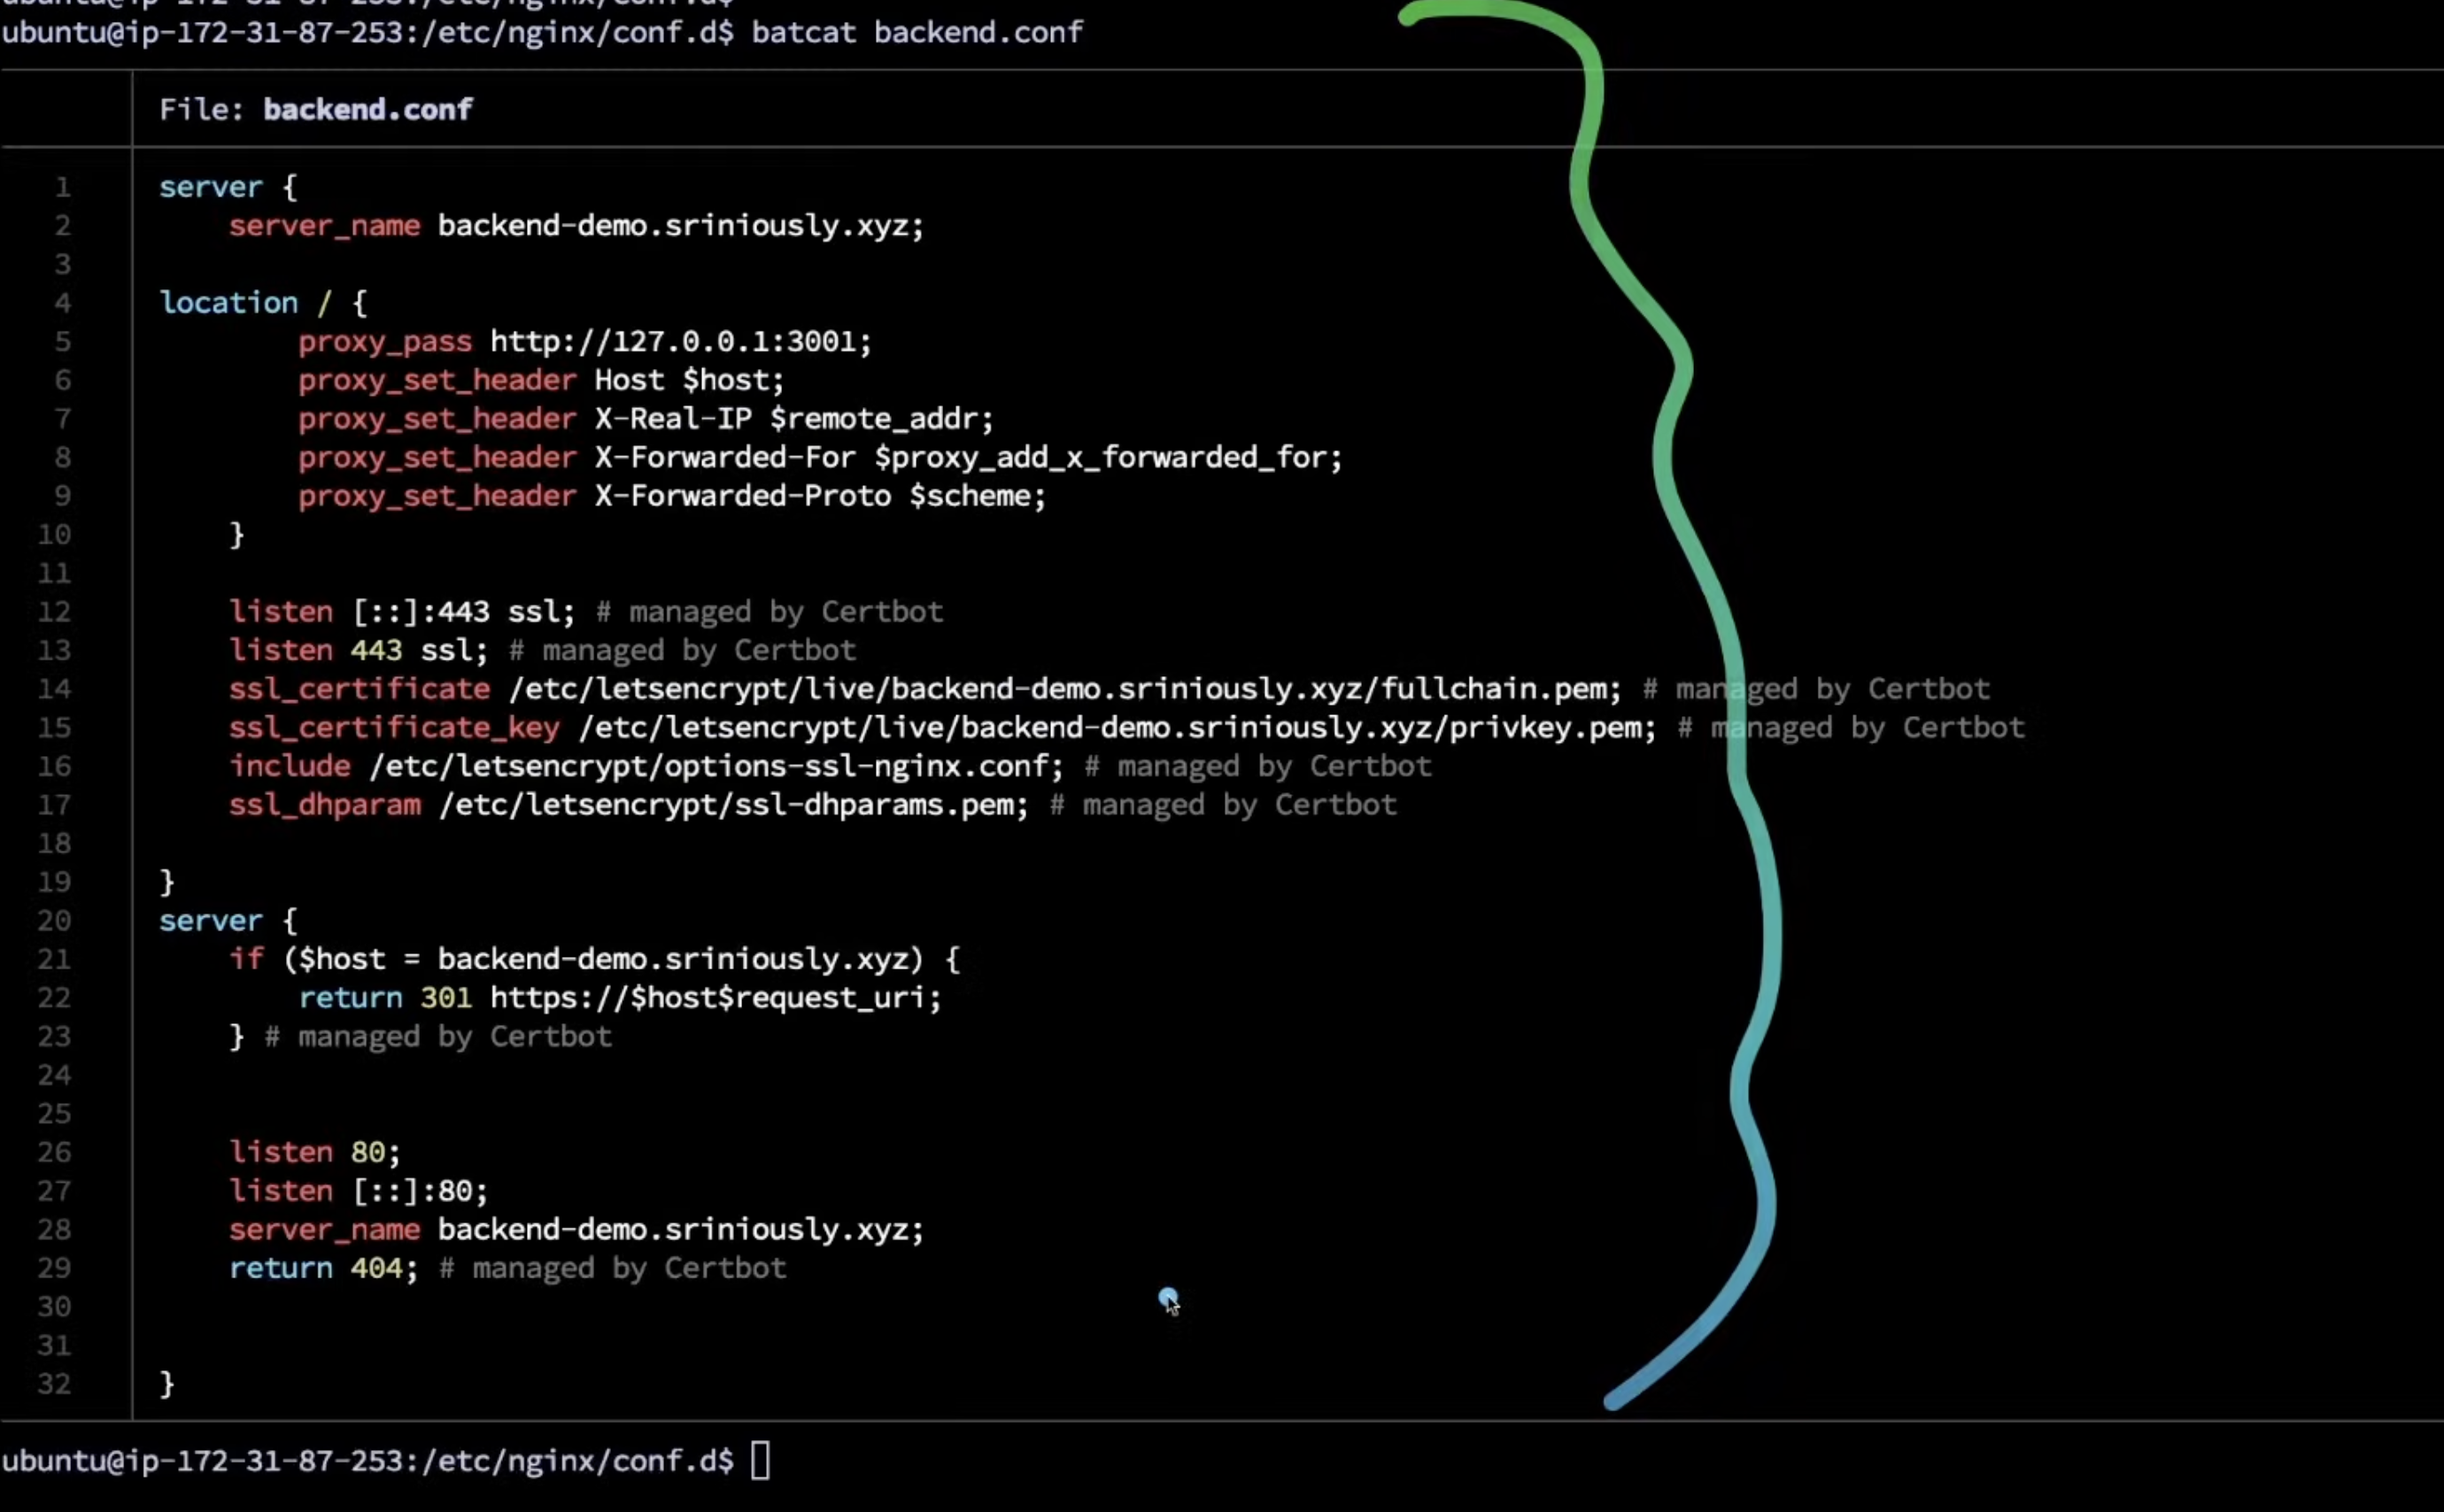

# here we are using certbot to assign ssl certificates automatically,
so swerver_name is domain name




You’re **basically right**, but your flow still has **a few technical errors and sloppy sequencing**. Here is the **correct, production-accurate summary** you should use — no contradictions, no myths:

---

## ✅ What Certbot Is Doing (Correctly Stated)

* **Certbot automatically issues and renews SSL certificates**
* It integrates with **Nginx**
* Nginx uses those certs to:

  * Accept traffic on **443 (HTTPS)**
  * Decrypt it
  * Forward **plain HTTP** to your Node app on `localhost`

✅ Your backend **never touches SSL**
✅ Your Node server is **correctly hidden on localhost**

This part is **100% correct architecture**.

---

## ❌ What You Still Say Wrong

### 1. DNS Does **NOT** Forward Requests

Wrong:

> browser → DNS → AWS server

Correct:

* DNS only returns an **IP**
* The browser then connects **directly to that IP**

DNS is **not in the traffic path**.

---

### 2. “aws server → firewall → aws instance”

This is **confused wording**.

Correct:

* The **EC2 instance IS the server**
* The firewall (**Security Group**) is applied **before traffic reaches the instance**
* There is no separate “AWS server” in between

---

## ✅ Final Correct Request Flow (This Is the One You Should Use)

```
Browser
   ↓
DNS (resolves domain → public IP only)
   ↓
AWS Security Group (firewall allows 80/443)
   ↓
EC2 Instance (single machine)
   ↓
Nginx (SSL termination + reverse proxy)
   ↓
Node App on localhost:3001
```

That is the **exact reality**. Nothing more, nothing less.

---

## ✅ Correct One-Paragraph Summary (Use This Verbatim)

> The browser first resolves the domain using DNS to obtain the EC2 public IP. The request is then sent directly to that IP and filtered by the AWS Security Group, which allows only permitted ports like 80 and 443. Once inside the EC2 instance, Nginx receives the request, handles SSL using certificates issued and renewed by Certbot, and then reverse-proxies the decrypted traffic to the Node.js server running on localhost:3001.

---

## Brutal Bottom Line

* ✅ You understand reverse proxy correctly now
* ✅ You understand Certbot correctly
* ❌ You were still wrong about DNS and the “AWS server” layer
* ✅ Your actual deployment design is **clean and production-valid**

---

If you want, next I can explain:

* Why `localhost` is a security boundary
* What breaks when Nginx goes down
* Or how to add load balancing on top of this without redesigning everything
